In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
import warnings; warnings.filterwarnings("ignore", category = FutureWarning)

cproj = cartopy.crs.PlateCarree()

# define study region
# xn, xx, yn, yx = [24.5,26.5,40.5,41.5]
xn, xx, yn, yx = [5,15,45,57]

In [2]:

px = pd.DataFrame({k : get_latlon(k) for k in ["Frankfurt", "Cuxhaven", "Gottingen", "Weinheim"]}).transpose()

In [3]:
tmplt = xr.open_dataset("../../Data/mswep_3hr/2020330.18.nc").isel(time = 0)

In [4]:
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.mask(tmplt.lon, tmplt.lat)

In [ ]:
rm.plot()

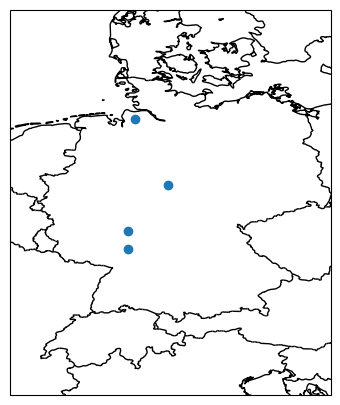

In [5]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj, "extent" : [xn, xx, yn, yx]}, figsize = (14,5), dpi = 100)
# ax.gridlines(draw_labels = True)
ax.add_feature(cartopy.feature.BORDERS)
ax.coastlines()

ax.scatter(px.lon, px.lat)

---
# **Questions**
- What would be the most appropriate metric? Cumulative DSR or something shorter-term? What actually caused the fires?
- Which areas should we consider?


---
# **Fire weather + burned area**
- [Rhodes](https://docs.google.com/document/d/13NjZDUwLz7O-kAbmJqyzaWUzQxyqirbr6V04fbB-SfY) - July 17th
- [Sardinia](https://docs.google.com/document/d/1p7PC3FKLxIwq8h5a5kXxJ_jEMgZnAdsb1ERJUk7SkrI) - August 6th
- [Spain & Portugal](https://docs.google.com/document/d/1Us-ZjOtClodkA5PLh11pJ_semp357tyn_3w6ecNwG6I/edit) - August 10th
- [Alexandroupoli](https://docs.google.com/document/d/1-2Vxb3IcZVx5sBCvWrYhNeCr8G_rlhR_WAquAGMQHDc) - August 18th

In [2]:
fwi = xr.open_dataset("data/era5_fwi_-10_40_35_50.nc").fwinx
dsr = ((fwi ** 1.77) * 0.0272).assign_attrs(long_name = "Daily severity rating").rename("dsr")

mdsr = dsr.resample(time = "MS").sum().assign_attrs(long_name = "Monthly DSR").rename("mdsr")
mdsr = mdsr.where(mdsr > 0)

In [3]:
ba = gpd.read_file("effis_burnedarea2023", parse_dates = ["FIREDATE"])
ba.index = pd.to_datetime(ba.FIREDATE)

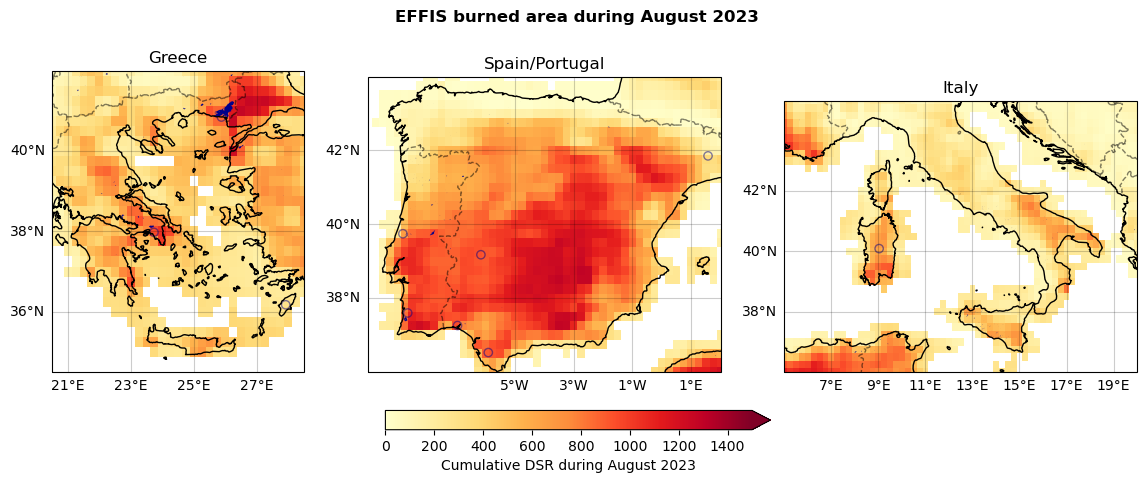

In [43]:
fig, axs = plt.subplots(ncols = 3, subplot_kw = {"projection" : cproj}, figsize = (14,5), dpi = 100, gridspec_kw = {"width_ratios" : [1,1.4,1.4]})
plot_kwargs = {"cmap" : "YlOrRd", "add_colorbar" : False, "vmin" : 0, "vmax" : 1500}

sites = [["Athens, GR", "Alexandroupoli", "Rhodes, GR"],
         ["Odemira", "Leiria", "Estremadura", "Cadiz", "Huelva", "Catalonia"],
         ["Sardinia"]]
extents = [[20.5, 28.5, 34.5,42], [-10,2,36,44], [5,20,36,45]]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for i in range(3):
    
    xn, xx, yn, yx = extents[i]
    px = {k : get_latlon(k) for k in sites[i]}
    ax = axs[i]

    mdsr_sub = mdsr.sel(longitude = slice(xn, xx), latitude = slice(yn, yx))
    ba_sub = ba.clip([xn,xx,yn,yx])

    cbar = mdsr_sub.sel(time = "2023-08").plot(ax = ax, **plot_kwargs)
    ba_sub.loc["2023-08"].plot(ax = ax, color = "darkblue")
    [ax.scatter(v["lon"], v["lat"], marker = "o", facecolors = "none", edgecolor = "darkblue", alpha = 0.5) for v in px.values()]
    
    ax.set_extent([xn,xx,yn,yx])
    ax.set_title(["Greece", "Spain/Portugal", "Italy"][i])
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.gridlines(draw_labels = ["bottom", "left"], color = "k", alpha = 0.2, xlocs = range(-5,28,2), ylocs = range(34,44,2))
    
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.1, label = "Cumulative DSR during August 2023", extend = "max")
plt.suptitle("EFFIS burned area during August 2023", fontweight = "bold", y = 0.95)
plt.savefig("fig/effis-burned-area_august-2023.png")

## **Greece**

In [4]:
xn, xx, yn, yx = [20.5, 28.5, 34.5,42]

mdsr_sub = mdsr.sel(longitude = slice(xn, xx), latitude = slice(yn, yx))
px = {k : get_latlon(k) for k in ["Athens, GR", "Alexandroupoli", "Rhodes, GR"]}
ba_sub = ba.clip([xn,xx,yn,yx])

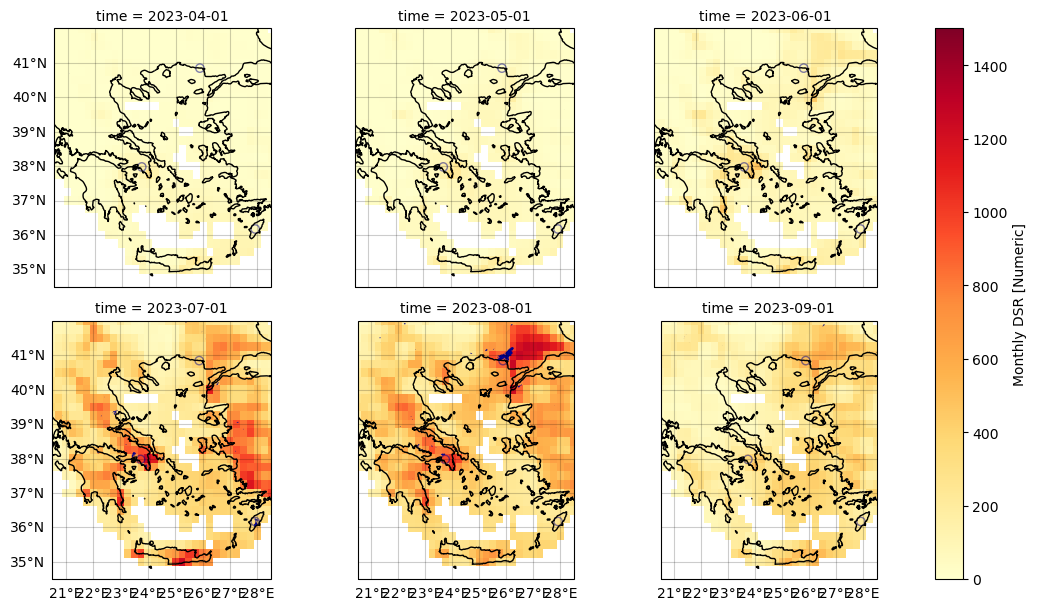

In [120]:
mdsr_sub.sel(time = slice("2023-04", None)).plot(col = "time", col_wrap = 3, figsize = (12,6), cmap = "YlOrRd", sharex = True, sharey = True,
                                                 vmin = 0, vmax = 1500, subplot_kws = {"projection" : cproj, "extent" : [xn,xx,yn,yx]})

axs = plt.gcf().axes[:-1]

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.gridlines(draw_labels = False, color = "k", alpha = 0.2)
    [ax.scatter(v["lon"], v["lat"], marker = "o", facecolors = "none", edgecolor = "darkblue", alpha = 0.5) for v in px.values()]

for ax in [axs[0], axs[3]]: ax.gridlines(draw_labels = ["left"], color = "k", alpha = 0)
for ax in [axs[3], axs[4], axs[5]]: ax.gridlines(draw_labels = ["bottom"], color = "k", alpha = 0)

for i in range(6):
    d = ["2023-04", "2023-05", "2023-06", "2023-07", "2023-08", "2023-09"][i]
    ba_sub.loc[d].plot(ax = axs[i], color = "darkblue")

## **Spain**

In [123]:
xn, xx, yn, yx = [-10,2,36,44]

mdsr_sub = mdsr.sel(longitude = slice(xn, xx), latitude = slice(yn, yx))
px = {k : get_latlon(k) for k in ["Odemira", "Leiria", "Estremadura", "Cadiz", "Huelva", "Catalonia"]}
ba_sub = ba.clip([xn,xx,yn,yx])

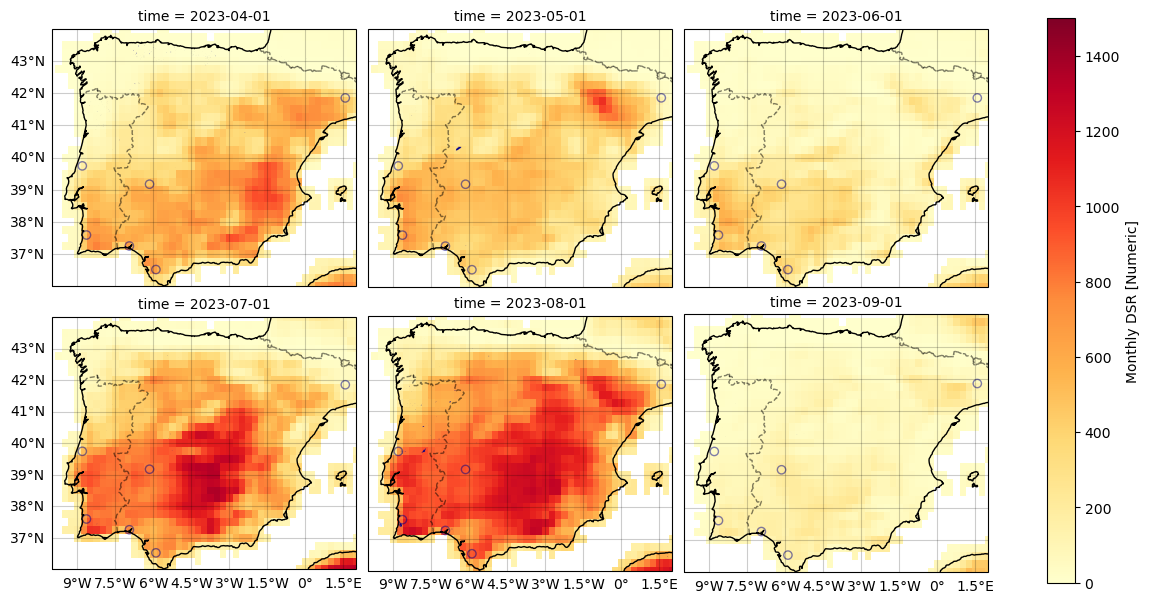

In [124]:
mdsr_sub.sel(time = slice("2023-04", None)).plot(col = "time", col_wrap = 3, figsize = (12,6), cmap = "YlOrRd", sharex = True, sharey = True,
                                                 vmin = 0, vmax = 1500, subplot_kws = {"projection" : cproj, "extent" : [xn,xx,yn,yx]})

axs = plt.gcf().axes[:-1]

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.gridlines(draw_labels = False, color = "k", alpha = 0.2)
    [ax.scatter(v["lon"], v["lat"], marker = "o", facecolors = "none", edgecolor = "darkblue", alpha = 0.5) for v in px.values()]

for ax in [axs[0], axs[3]]: ax.gridlines(draw_labels = ["left"], color = "k", alpha = 0)
for ax in [axs[3], axs[4], axs[5]]: ax.gridlines(draw_labels = ["bottom"], color = "k", alpha = 0)

for i in range(6):
    d = ["2023-04", "2023-05", "2023-06", "2023-07", "2023-08", "2023-09"][i]
    ba_sub.loc[d].plot(ax = axs[i], color = "darkblue")

## **Italy**

In [182]:
xn, xx, yn, yx = [5,20,36,45]

mdsr_sub = mdsr.sel(longitude = slice(xn, xx), latitude = slice(yn, yx))
px = {k : get_latlon(k) for k in ["Sardinia"]}
ba_sub = ba.clip([xn,xx,yn,yx])

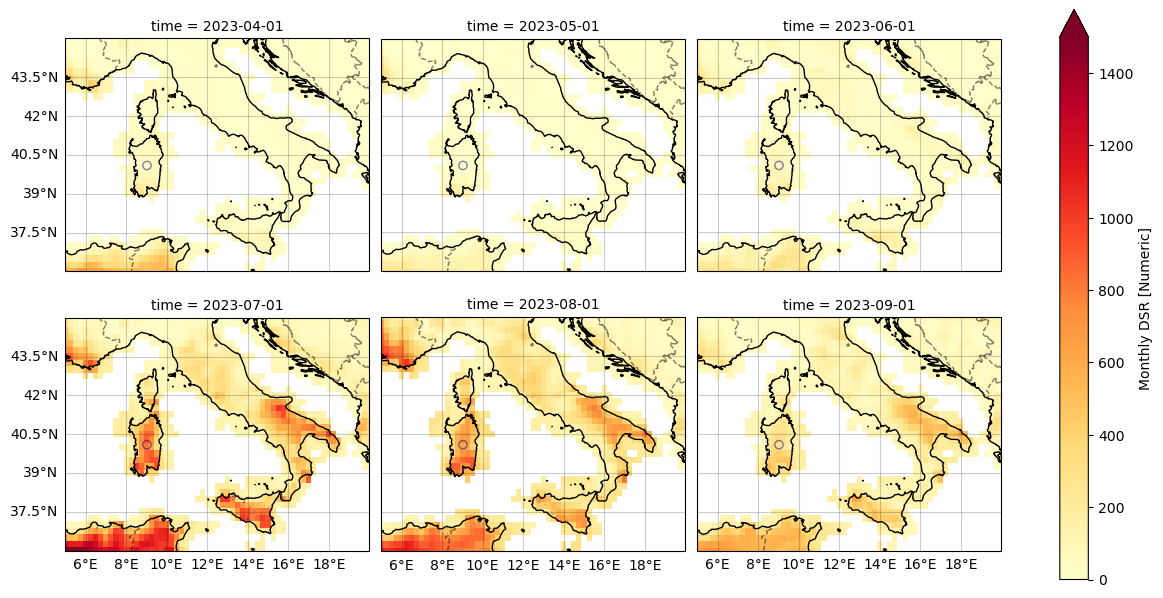

In [183]:
mdsr_sub.sel(time = slice("2023-04", None)).plot(col = "time", col_wrap = 3, figsize = (12,6), cmap = "YlOrRd", sharex = True, sharey = True,
                                                 vmin = 0, vmax = 1500, subplot_kws = {"projection" : cproj, "extent" : [xn,xx,yn,yx]})

axs = plt.gcf().axes[:-1]

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.gridlines(draw_labels = False, color = "k", alpha = 0.2)
    [ax.scatter(v["lon"], v["lat"], marker = "o", facecolors = "none", edgecolor = "darkblue", alpha = 0.5) for v in px.values()]

for ax in [axs[0], axs[3]]: ax.gridlines(draw_labels = ["left"], color = "k", alpha = 0)
for ax in [axs[3], axs[4], axs[5]]: ax.gridlines(draw_labels = ["bottom"], color = "k", alpha = 0)

for i in range(6):
    d = ["2023-04", "2023-05", "2023-06", "2023-07", "2023-08", "2023-09"][i]
    ba_sub.loc[d].plot(ax = axs[i], color = "darkblue")

# **Fire weather**


In [5]:
fwi = xr.open_dataset("data/era5_fwi_-10_40_35_50.nc").fwinx
dsr = ((fwi ** 1.77) * 0.0272).assign_attrs(long_name = "Daily severity rating").rename("dsr")
cdsr = dsr.sel(time = [m <= 8 for m in dsr.time.dt.month]).resample(time = "AS-JAN").sum()
cdsr = cdsr.where(cdsr > 0)

regions = {"Rhodes" : [27.5, 28.5, 35.5, 36.5], "Alexandropouli" : [25, 27, 40.5, 41.5], "Portugal" : [-9,-6,37,42], "Sardinia" : [8,10,39,41]}
triggers = {"Rhodes": "2020-07-17", "Sardinia" : "2020-08-06", "Portugal" : "2020-08-10", "Alexandropouli" : "2020-08-18"}

## **Map of 2023 DSR & subregions**


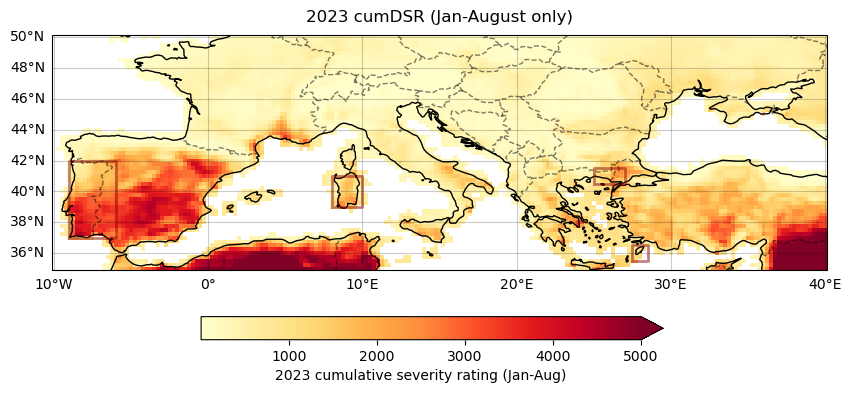

In [17]:
fig = cdsr.sel(time = "2023").plot(cmap = "YlOrRd", subplot_kws = {"projection" : cproj}, figsize = (10,6), vmax = 5000,
                                              cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.1,
                                                             "label" : "2023 cumulative severity rating (Jan-Aug)"})
ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
ax.gridlines(draw_labels = ["bottom", "left"], color = "k", alpha = 0.2)

for r in regions:
    xn,xx,yn,yx = regions[r]
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)

ax.set_title("2023 cumDSR (Jan-August only)")
plt.savefig("fig/cumDSR_2023.png")

## **Map of extremity of log10(cumDSR)**


In [7]:
log10_cdsr = np.log10(cdsr)
log10_cdsr_2023 = (log10_cdsr.sel(time = "2023") - log10_cdsr.sel(time = slice("1990", "2020")).mean()) / log10_cdsr.sel(time = slice("1990", "2020")).std()
log10_cdsr_2023 = log10_cdsr_2023.where(log10_cdsr.mean("time") > 0)

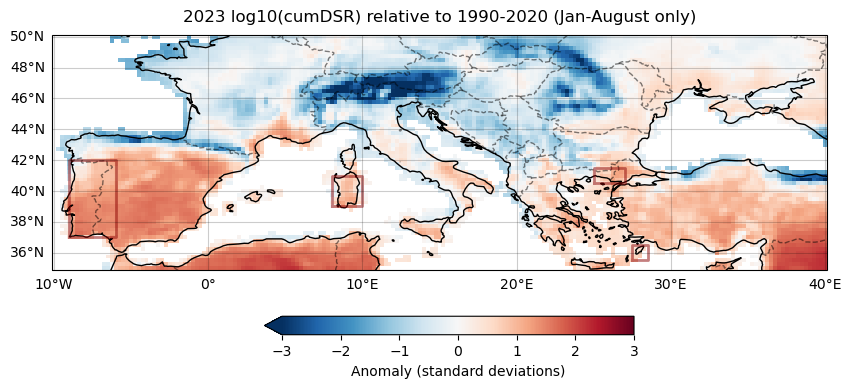

In [9]:
fig = log10_cdsr_2023.plot(subplot_kws = {"projection" : cproj}, figsize = (10,6), vmin = -3, vmax = 3, cmap = "RdBu_r",
                     cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.1, "label" : "Anomaly (standard deviations)"})
ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
ax.gridlines(draw_labels = ["bottom", "left"], color = "k", alpha = 0.2)

for r in regions:
    xn,xx,yn,yx = regions[r]
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)
    
ax.set_title("2023 log10(cumDSR) relative to 1990-2020 (Jan-August only)")

plt.savefig("fig/cumDSR_standardised-anomaly.png")

## **FWI in each region**

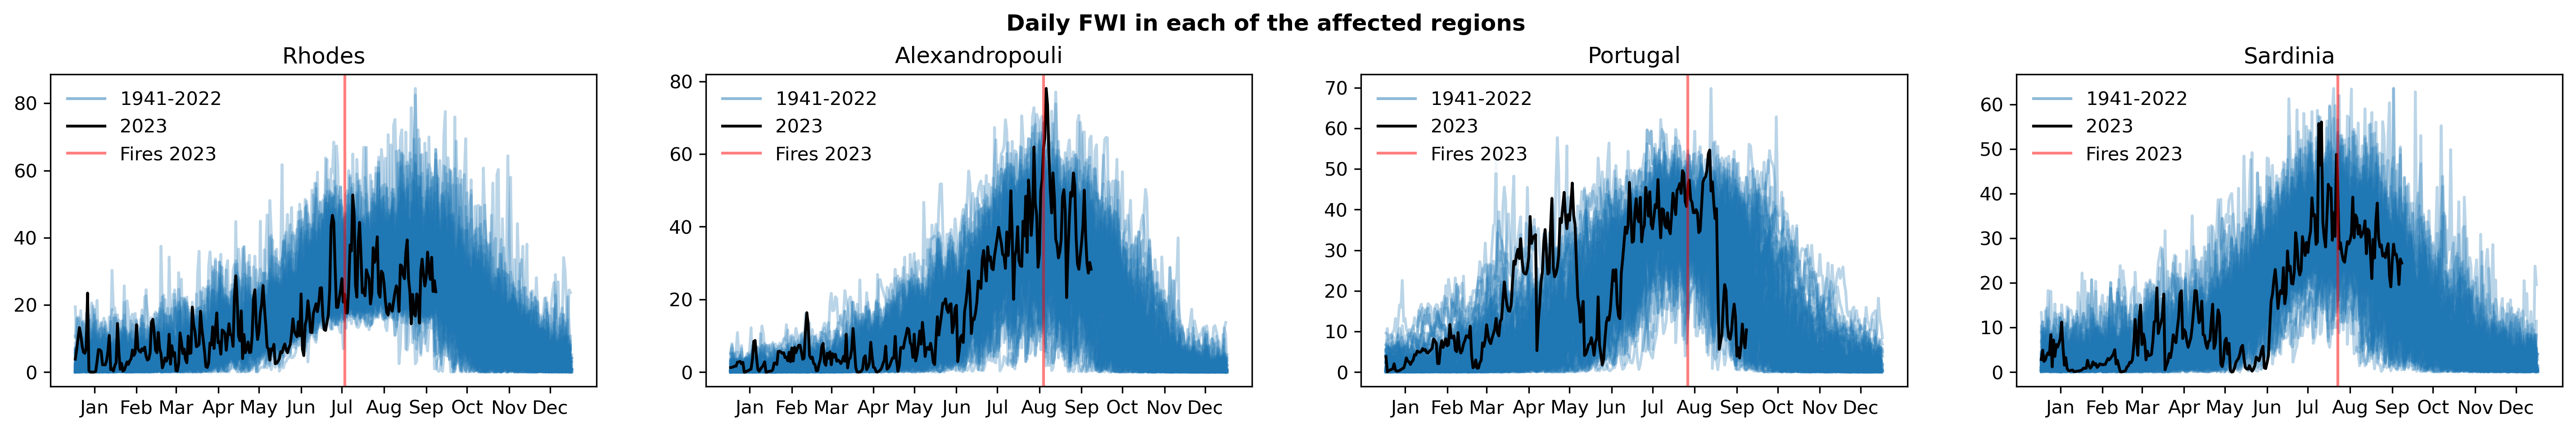

In [12]:
nr = 4
fig, axs = plt.subplots(ncols = nr, dpi = 300, figsize = (nr*6,3))

for i in range(nr):
    r = list(regions.keys())[i]
    ts_ax = axs[i]
    xn,xx,yn,yx = regions[r]
    d = triggers[r]
    fwi_ts = fwi.sel(longitude = slice(xn,xx), latitude = slice(yn,yx)).mean(["latitude", "longitude"])
    
    for y in range(1941,2022):
        fwi_y = fwi_ts.sel(time = str(y))
        ts_ax.plot(fwi_y.time.dt.dayofyear, fwi_y, color = "tab:blue", alpha = 0.3)

    y = 2022
    fwi_y = fwi_ts.sel(time = str(y))
    ts_ax.plot(fwi_y.time.dt.dayofyear, fwi_y, color = "tab:blue", alpha = 0.5, label = "1941-2022")
    
    y = 2023
    fwi_y = fwi_ts.sel(time = str(y))
    ts_ax.plot(fwi_y.time.dt.dayofyear, fwi_y, color = "k", alpha = 1, label = "2023")
    
    ts_ax.axvline(pd.to_datetime(d).dayofyear, color = "red", alpha = 0.5, label = "Fires 2023")
    
    days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
    labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
    labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 1]
    ts_ax.set_xticks(labelticks)
    ts_ax.set_xticklabels(labels)
    
    ts_ax.set_title(r)
    
    ts_ax.legend(loc = "upper left", edgecolor = "w")
    
plt.suptitle("Daily FWI in each of the affected regions", fontweight = "bold", y = 1.03)
plt.savefig("fig/daily-fwi.png")

## **cumDSR in each region**

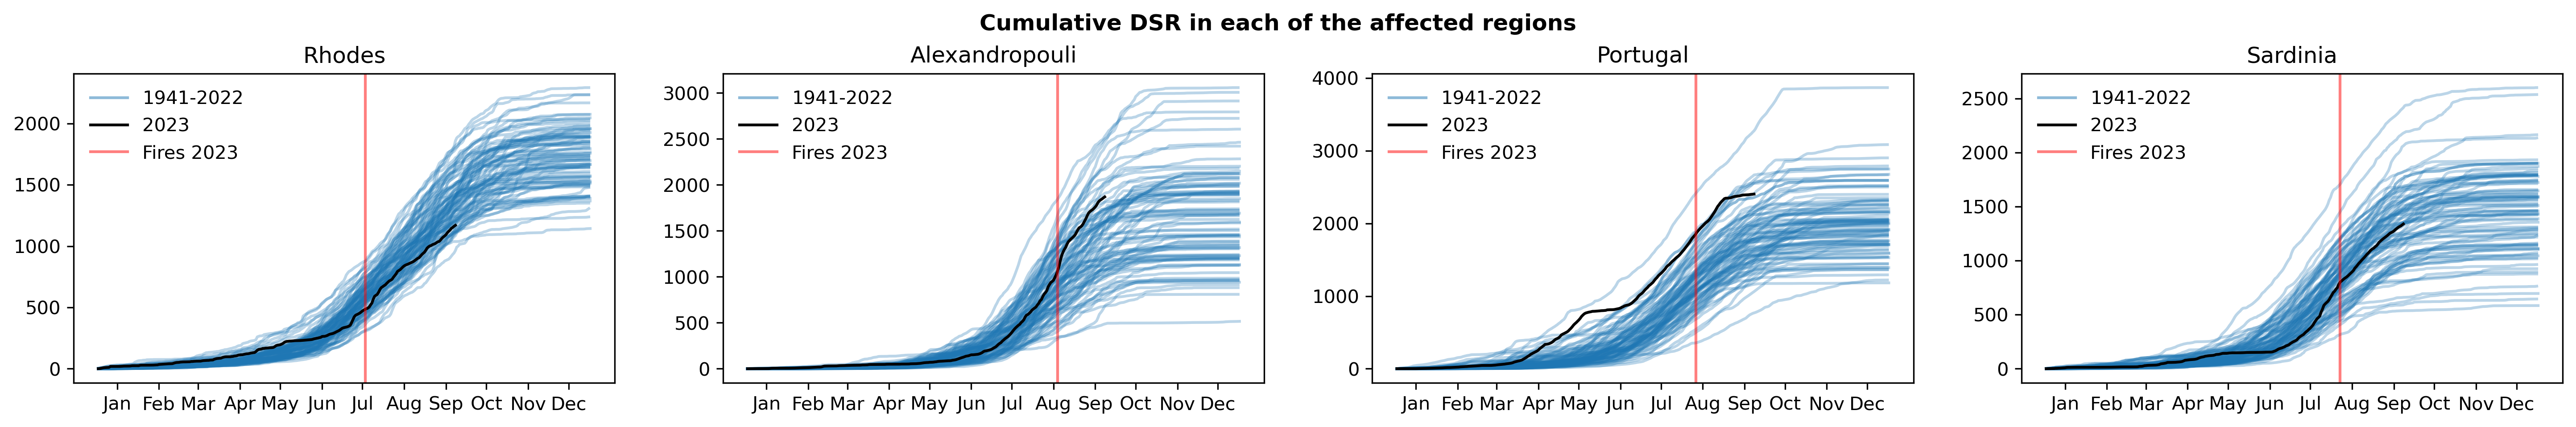

In [13]:
nr = 4
fig, axs = plt.subplots(ncols = nr, dpi = 300, figsize = (nr*6,3))

for i in range(nr):
    r = list(regions.keys())[i]
    ts_ax = axs[i]
    xn,xx,yn,yx = regions[r]
    d = triggers[r]
    dsr_ts = dsr.sel(longitude = slice(xn,xx), latitude = slice(yn,yx)).mean(["latitude", "longitude"])
    
    for y in range(1941,2022):
        dsr_y = dsr_ts.sel(time = str(y))
        ts_ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "tab:blue", alpha = 0.3)

    y = 2022
    dsr_y = dsr_ts.sel(time = str(y))
    ts_ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "tab:blue", alpha = 0.5, label = "1941-2022")
    
    y = 2023
    dsr_y = dsr_ts.sel(time = str(y))
    ts_ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "k", alpha = 1, label = "2023")
    
    ts_ax.axvline(pd.to_datetime(d).dayofyear, color = "red", alpha = 0.5, label = "Fires 2023")
    
    days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
    labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
    labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 1]
    ts_ax.set_xticks(labelticks)
    ts_ax.set_xticklabels(labels)
    
    ts_ax.set_title(r)
    
    ts_ax.legend(loc = "upper left", edgecolor = "w")
    
plt.suptitle("Cumulative DSR in each of the affected regions", fontweight = "bold", y = 1.03)
plt.savefig("fig/cumDSR.png")

## **Trend in Jan-Aug cumDSR in each region**

In [15]:
cdsr_ann = cdsr.resample(time = "AS-JAN").max()

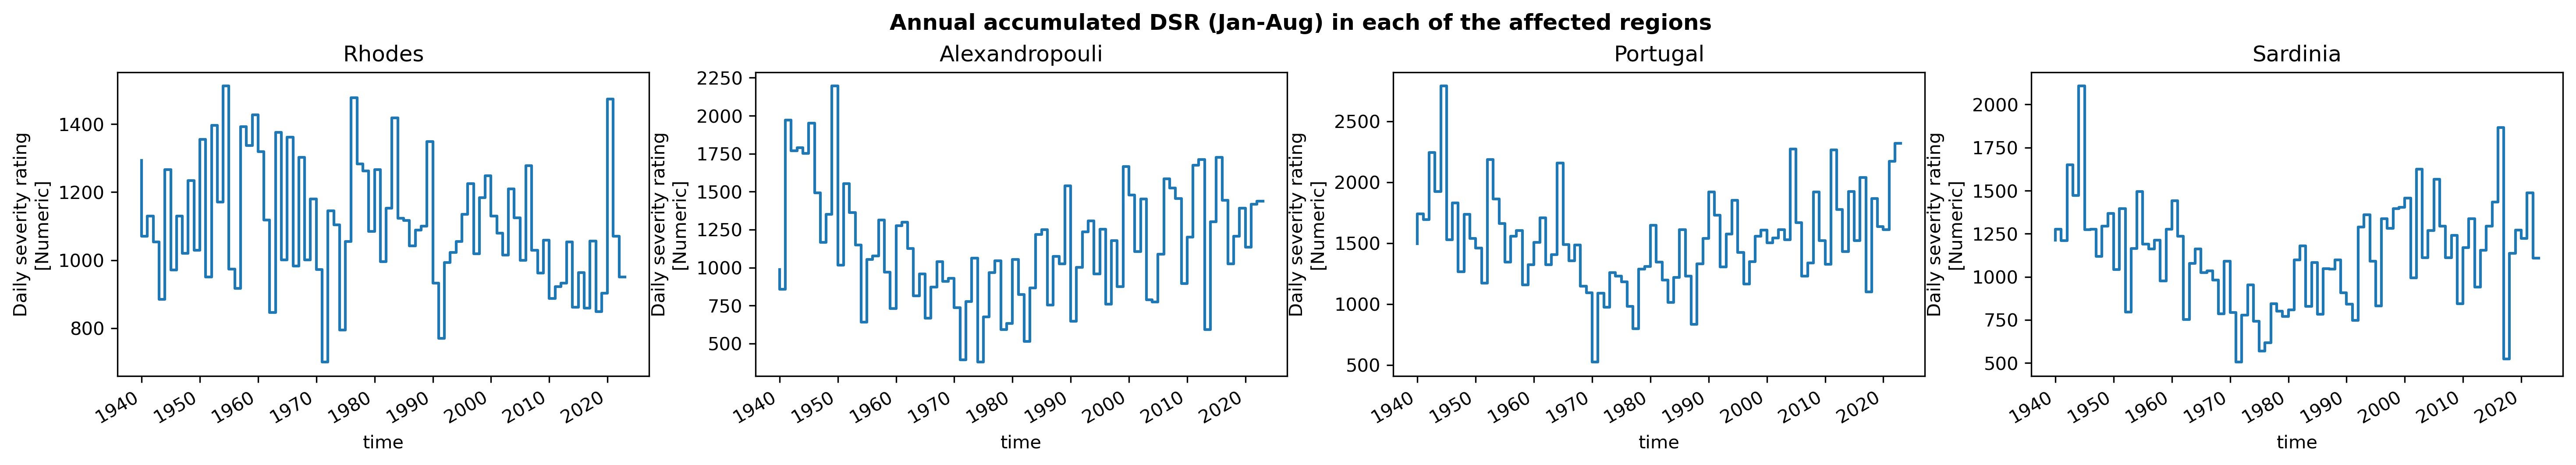

In [16]:
nr = 4
fig, axs = plt.subplots(ncols = nr, dpi = 300, figsize = (nr*6,3))

for i in range(nr):
    r = list(regions.keys())[i]
    ts_ax = axs[i]
    xn,xx,yn,yx = regions[r]
    d = triggers[r]
    dsr_ts = cdsr_ann.sel(longitude = slice(xn,xx), latitude = slice(yn,yx)).mean(["latitude", "longitude"])
    
    dsr_ts.plot(ax = ts_ax, drawstyle = "steps")
    
    ts_ax.set_title(r)
    
plt.suptitle("Annual accumulated DSR (Jan-Aug) in each of the affected regions", fontweight = "bold", y = 1.03)
plt.savefig("fig/cumDSR-trend.png")

---
# **Fire activity**

Thermal anomaly data from https://firms.modaps.eosdis.nasa.gov/active_fire/  
EFFIS summaries with confidence intervals from https://effis.jrc.ec.europa.eu/apps/effis.statistics/seasonaltrend

## **EFFIS burned area**

In [23]:
ba = gpd.read_file("effis_burnedarea2023", parse_dates = ["FIREDATE"])
ba = ba.loc[[d[:4] == "2023" for d in ba.FIREDATE]]

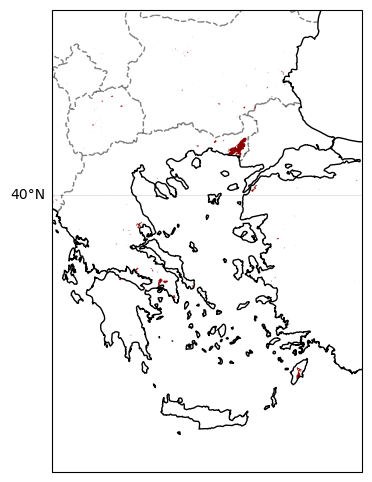

In [38]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (6,6), dpi = 100, subplot_kw = {"projection" : cproj, "extent" : [20,30,34,44]}, sharex = True, sharey = True)

ba.plot(ax = ax, color = "darkred")

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-30,70,10), ylocs = range(30,70,10))

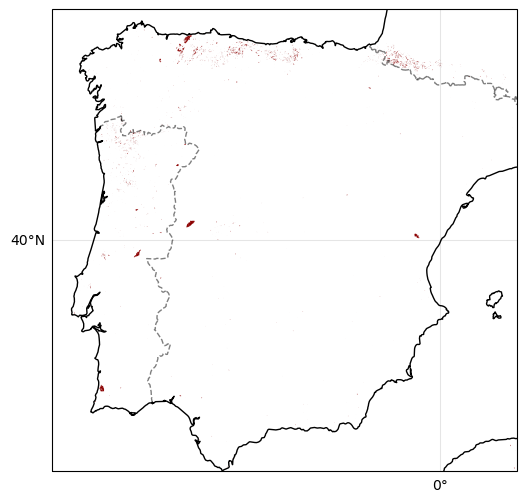

In [43]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (6,6), dpi = 100, subplot_kw = {"projection" : cproj, "extent" : [-10,2,36,44]}, sharex = True, sharey = True)

ba.plot(ax = ax, color = "darkred")

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-30,70,10), ylocs = range(30,70,10))

## **Maps of thermal anomalies**

### **Europe**

#### **2023**

In [2]:
px = {k : get_latlon(k) for k in ["Alexandroupoli", "Rhodes", "Sardinia", "Chelyabinsk", "Odemira", "Cadiz"]}

In [3]:
modis = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"]) for fnm in glob.glob("data/fire_*_M-C61_*.csv")])
modis["y"] = [d.year for d in modis.acq_date]
modis["m"] = [d.month for d in modis.acq_date]
modis = gpd.GeoDataFrame(modis, geometry = gpd.points_from_xy(x=modis.longitude, y=modis.latitude), crs = "EPSG:4326")

In [4]:
viirs = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"]) for fnm in glob.glob("data/fire_*_SV-C2_*.csv")])
viirs["y"] = [d.year for d in viirs.acq_date]
viirs["m"] = [d.month for d in viirs.acq_date]
viirs = gpd.GeoDataFrame(viirs, geometry = gpd.points_from_xy(x=viirs.longitude, y=viirs.latitude), crs = "EPSG:4326")

In [ ]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (6,6), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)
modis.loc[(modis.y == 2023) & (modis.confidence >= 80) & ((modis["type"] == 0.0))].plot(ax = ax, marker = ".", color = "tab:red", alpha = 0.7, markersize = 0.1)
ax.coastlines()

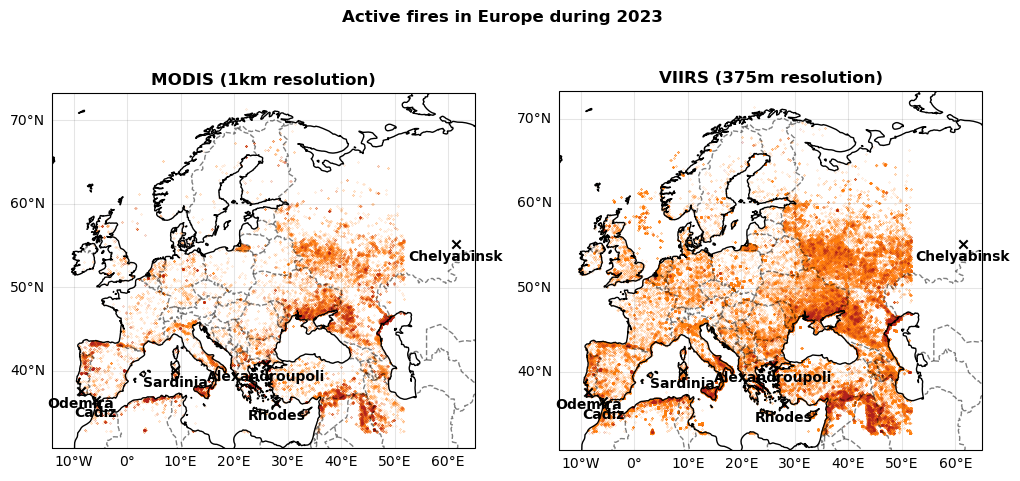

In [35]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12,6), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)

modis.loc[(modis.y == 2023) & (modis.confidence >= 60) & ((modis["type"] == 0.0) | np.isnan(modis["type"]))].plot(ax = axs[0], marker = ".", color = "tab:orange", alpha = 0.7, markersize = 0.1)
modis.loc[(modis.y == 2023) & (modis.confidence >= 90) & ((modis["type"] == 0.0) | np.isnan(modis["type"]))].plot(ax = axs[0], marker = ".", color = "firebrick", alpha = 0.7, markersize = 0.1)
axs[0].set_title("MODIS (1km resolution)", fontweight = "bold")

viirs.loc[(viirs.y == 2023) & (viirs.confidence == "n") & ((viirs["type"] == 0.0) | np.isnan(viirs["type"]))].plot(ax = axs[1], marker = ".", color = "tab:orange", alpha = 0.7, markersize = 0.1)
viirs.loc[(viirs.y == 2023) & (viirs.confidence == "h") & ((viirs["type"] == 0.0) | np.isnan(viirs["type"]))].plot(ax = axs[1], marker = ".", color = "firebrick", alpha = 0.7, markersize = 0.1)
axs[1].set_title("VIIRS (375m resolution)", fontweight = "bold")

for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-30,70,10))
    [ax.scatter(v["lon"], v["lat"], marker = "x", color = "k") for v in px.values()]
    [ax.annotate(k, xy = v.values(), fontweight = "bold", textcoords="offset points", xytext=(0,-12), ha='center') for k, v in px.items()]
    
    # ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)
    
plt.suptitle("Active fires in Europe during 2023", fontweight = "bold", y = 0.93)
plt.savefig("fig/active-fires-2023-europe.png")

### **Greece**

#### **2007**

In [481]:
px = {k : get_latlon(k) for k in ["Athens", "Alexandroupoli", "Rhodes"]}

modis = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"]) for fnm in glob.glob("data/modis_GRC_*.csv")])
modis["y"] = [d.year for d in modis.acq_date]
modis = gpd.GeoDataFrame(modis, geometry = gpd.points_from_xy(x=modis.longitude, y=modis.latitude), crs = "EPSG:4326")

viirs = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"]) for fnm in glob.glob("data/viirs_GRC_*.csv")])
viirs["y"] = [d.year for d in viirs.acq_date]
viirs = gpd.GeoDataFrame(viirs, geometry = gpd.points_from_xy(x=viirs.longitude, y=viirs.latitude), crs = "EPSG:4326")

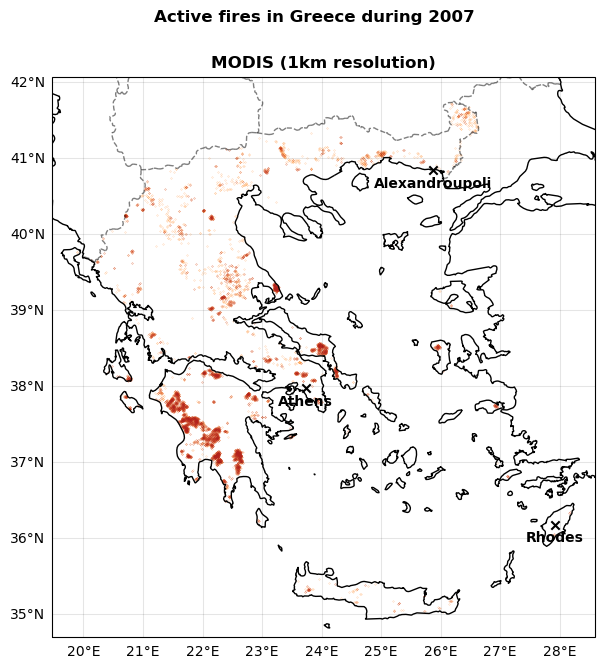

In [485]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (7,8), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)

modis.loc[(modis.y == 2007) & (modis.confidence >= 60)].plot(ax = ax, marker = ".", color = "tab:orange", alpha = 0.7, markersize = 0.1)
modis.loc[(modis.y == 2007) & (modis.confidence >= 80)].plot(ax = ax, marker = ".", color = "firebrick", alpha = 0.7, markersize = 0.1)
ax.set_title("MODIS (1km resolution)", fontweight = "bold")

# viirs.loc[(viirs.y == 2007) & (viirs.confidence == "n")].plot(ax = axs[1], marker = ".", color = "tab:orange", alpha = 0.7, markersize = 0.1)
# viirs.loc[(viirs.y == 2007) & (viirs.confidence == "h")].plot(ax = axs[1], marker = ".", color = "firebrick", alpha = 0.7, markersize = 0.1)
# axs[1].set_title("VIIRS (375m resolution)", fontweight = "bold")

for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(19,29))
    [ax.scatter(v["lon"], v["lat"], marker = "x", color = "k") for v in px.values()]
    [ax.annotate(k, xy = v.values(), fontweight = "bold", textcoords="offset points", xytext=(0,-12), ha='center') for k, v in px.items()]
    
plt.suptitle("Active fires in Greece during 2007", fontweight = "bold", y = 0.93)
plt.savefig("fig/active-fires-2007-greece.png")

### **Turkey**

In [331]:
px = {k : get_latlon(k) for k in ["Ankara", "Istanbul", "Gaziantep"]}

modis = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"]) for fnm in glob.glob("data/modis_TRK_*.csv")])
modis["y"] = [d.year for d in modis.acq_date]
modis = gpd.GeoDataFrame(modis, geometry = gpd.points_from_xy(x=modis.longitude, y=modis.latitude), crs = "EPSG:4326")

viirs = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"]) for fnm in glob.glob("data/viirs_TRK_*.csv")])
viirs["y"] = [d.year for d in viirs.acq_date]
viirs = gpd.GeoDataFrame(viirs, geometry = gpd.points_from_xy(x=viirs.longitude, y=viirs.latitude), crs = "EPSG:4326")

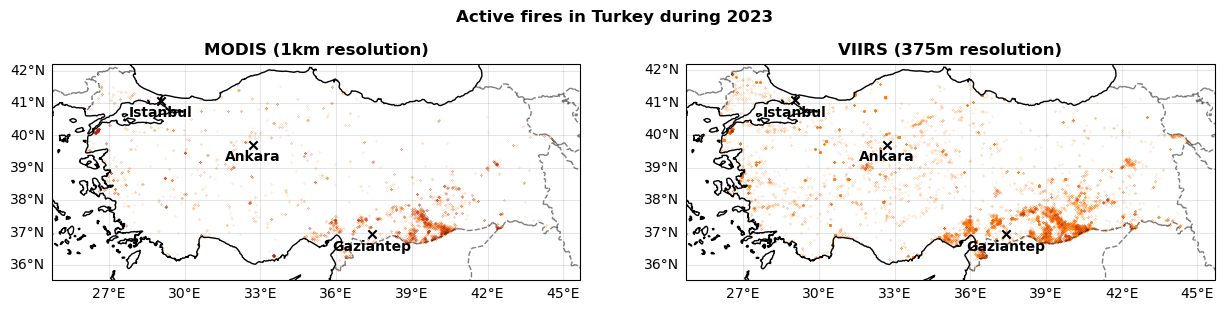

In [333]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (15,4), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)

modis.loc[(modis.y == 2023) & (modis.confidence >= 60)].plot(ax = axs[0], marker = ".", color = "tab:orange", alpha = 0.7, markersize = 0.1)
modis.loc[(modis.y == 2023) & (modis.confidence >= 80)].plot(ax = axs[0], marker = ".", color = "firebrick", alpha = 0.7, markersize = 0.1)
axs[0].set_title("MODIS (1km resolution)", fontweight = "bold")

viirs.loc[(viirs.y == 2023) & (viirs.confidence == "n")].plot(ax = axs[1], marker = ".", color = "tab:orange", alpha = 0.7, markersize = 0.1)
viirs.loc[(viirs.y == 2023) & (viirs.confidence == "h")].plot(ax = axs[1], marker = ".", color = "firebrick", alpha = 0.7, markersize = 0.1)
axs[1].set_title("VIIRS (375m resolution)", fontweight = "bold")

for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])
    [ax.scatter(v["lon"], v["lat"], marker = "x", color = "k") for v in px.values()]
    [ax.annotate(k, xy = v.values(), fontweight = "bold", textcoords="offset points", xytext=(0,-12), ha='center') for k, v in px.items()]
    
plt.suptitle("Active fires in Turkey during 2023", fontweight = "bold", y = 0.9)
plt.savefig("fig/active-fires-2023-turkey.png")

## **Total fire activity over Greece**

In [459]:
modis = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"], index_col = "acq_date") for fnm in glob.glob("data/modis_GRC_*.csv")])
modis["i"] = 1

In [444]:
days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 1]

Text(0.5, 1.0, 'MODIS cumulative thermal anomalies (2001-2023)')

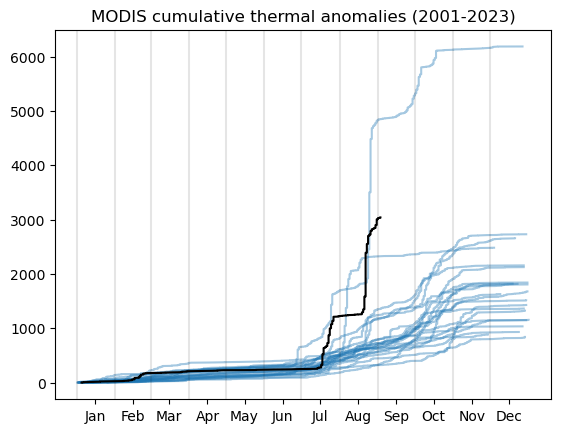

In [480]:
for y in range(2001,2023):
    plt.plot(modis.loc[str(y)].index.dayofyear, modis.loc[str(y), ["i"]].cumsum(), color = "tab:blue", alpha = 0.4)
y = 2023
plt.plot(modis.loc[str(y)].index.dayofyear, modis.loc[str(y), ["i"]].cumsum(), color = "k", alpha = 1)

ax = plt.gca()
ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
[ax.axvline(i, color = "k", alpha = 0.1) for i in range(366) if (days[i].day) == 1]
ax.set_title("MODIS cumulative thermal anomalies (2001-2023)")

# that huge spike is 2007

## **Check against EFFIS**

In [198]:
# load EFFIS cumulative data
emi = pd.read_csv("data/effis_emissions_emicum_GRC_2003_2022_2023.csv", skiprows = 1, index_col = 0, names = ["max", "mean", "min", "2023"])
ba = pd.read_csv("data/effis_seasonal-trend_bacum_GRC_2006_2022_2023.csv", skiprows = 1, index_col = 0, names = ["max", "mean", "min", "2023"])
tam = pd.read_csv("data/effis_seasonal-trend_tacum-modis_GRC_2012_2022_2023.csv", skiprows = 1, index_col = 0, names = ["max", "mean", "min", "2023"])
tav = pd.read_csv("data/effis_seasonal-trend_tacum-viirs_GRC_2012_2022_2023.csv", skiprows = 1, index_col = 0, names = ["max", "mean", "min", "2023"])

# convert index to datetime for neater plotting
emi, ba, tam, tav = [df.set_index(pd.date_range(start = "2023-01-07", end = "2023-12-30", freq = "7D")) for df in [emi, ba, tam, tav]]

# add first day of year with cumulative values of zero (otherwise plots start a week in)
emi, ba, tam, tav = [pd.concat([pd.DataFrame({k : 0 for  k in ["max", "mean", "min", "2023"]}, index = pd.DatetimeIndex(["2023-01-01"])), df]) for df in [emi, ba, tam, tav]]

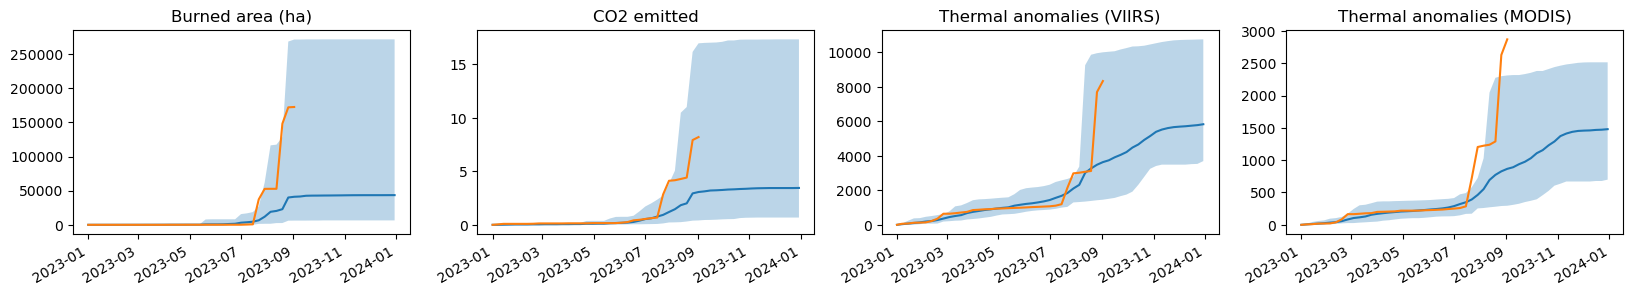

In [117]:
# plot EFFIS data
fig, axs = plt.subplots(ncols = 4, figsize = (20,3), dpi = 100)

for i in range(4):
    df = [ba, emi, tav, tam][i]
    ttl = ["Burned area (ha)", "CO2 emitted", "Thermal anomalies (VIIRS)", "Thermal anomalies (MODIS)"][i]

    axs[i].fill_between(df.index, df["min"], df["max"], alpha = 0.3)
    df["mean"].plot(ax = axs[i])
    df["2023"].plot(ax = axs[i])
    axs[i].set_title(ttl)


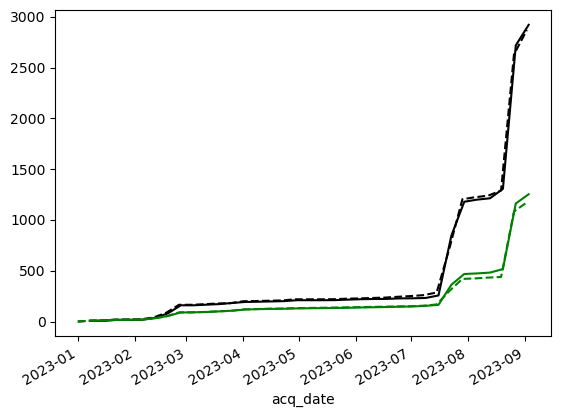

In [335]:
modis = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"]) for fnm in glob.glob("data/modis_GRC_*.csv")])
modis = modis.loc[[d.year == 2023 for d in modis.acq_date]]

viirs = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"]) for fnm in glob.glob("data/viirs_GRC_*.csv")])
viirs = viirs.loc[[d.year == 2023 for d in viirs.acq_date]]

modis_ba = modis.loc[modis.confidence >= 30, ["acq_date", "scan"]].resample("W", on = "acq_date", label = "right").count().cumsum()
viirs_ba = viirs.loc[[c in ["h", "n"] for c in viirs.confidence], ["acq_date", "scan"]].resample("W", on = "acq_date", label = "right").count().cumsum()

tam["2023"].plot(color = "k", ls = "--", label = "MODIS (EFFIS)")
modis_ba.plot(ax = plt.gca(), color = "k", label = "MODIS")

# VIIRS pixels are 375m - convert to actual area
(tav["2023"] * (375/1000)**2).plot(ax = plt.gca(), color = "green", ls = "--", label = "VIIRS (EFFIS)")
(viirs_ba * (375/1000)**2).plot(ax = plt.gca(), color = "green", label = "VIIRS")

plt.legend("", edgecolor = "w")